# Fine-tune SAM on customized datasets (2D example)
1. Prepare original 2D images `data/MedSAMDemo_2D/` (Download link:https://drive.google.com/file/d/18GhVEODbTi17jSeBXdeLQ7vHPdtlTYXK/view?usp=share_link) 
2. Run `pre_grey_rgb2D.py` for pre-processing. Expected output: `./data/demo2D_vit_b/demo2d.npz`
3. Start this fine-tuning tutorial

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import monai
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
from utils.SurfaceDice import compute_dice_coefficient
# set seeds
torch.manual_seed(2023)
np.random.seed(2023)

In [2]:
#%% create a dataset class to load npz data and return back image embeddings and ground truth
def get_box(x_min, x_max, y_min, y_max, H, W, margin=1):
    x_min = max(0, x_min - np.random.randint(0, margin))
    x_max = min(W, x_max + np.random.randint(0, margin))
    y_min = max(0, y_min - np.random.randint(0, margin))
    y_max = min(H, y_max + np.random.randint(0, margin))
    return x_min, x_max, y_min, y_max
class NpzDataset(Dataset): 
    def __init__(self, data_root):
        self.data_root = data_root
        self.npz_files = sorted(os.listdir(self.data_root)) 
        self.npz_data = [np.load(join(data_root, f)) for f in self.npz_files]
        # this implementation is ugly but it works (and is also fast for feeding data to GPU) if your server has enough RAM
        # as an alternative, you can also use a list of npy files and load them one by one
        self.ori_gts = np.vstack([d['gts'] for d in self.npz_data])
        self.img_embeddings = np.vstack([d['img_embeddings'] for d in self.npz_data])
        print(f"{self.img_embeddings.shape=}, {self.ori_gts.shape=}")
    
    def __len__(self):
        return self.ori_gts.shape[0]

    def __getitem__(self, index):
        img_embed = self.img_embeddings[index]
        gt2D = self.ori_gts[index]
        y_indices, x_indices = np.where(gt2D > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = gt2D.shape
        x_min, x_max, y_min, y_max = get_box(x_min, x_max, y_min, y_max, H, W, 1)
        bboxes = np.array([x_min, y_min, x_max, y_max])
        # convert img embedding, mask, bounding box to torch tensor
        return torch.tensor(img_embed).float(), torch.tensor(gt2D[None, :,:]).long(), torch.tensor(bboxes).float()

In [3]:
# %% test dataset class and dataloader
npz_tr_path = 'data/demo2D_vit_b'   # the path of preprocessed data
demo_dataset = NpzDataset(npz_tr_path)
demo_dataloader = DataLoader(demo_dataset, batch_size=8, shuffle=True) #batch size
for img_embed, gt2D, bboxes in demo_dataloader:
    # img_embed: (B, 256, 64, 64), gt2D: (B, 1, 256, 256), bboxes: (B, 4)
    print(f"{img_embed.shape=}, {gt2D.shape=}, {bboxes.shape=}")
    break

self.img_embeddings.shape=(199, 256, 64, 64), self.ori_gts.shape=(199, 256, 256)
img_embed.shape=torch.Size([8, 256, 64, 64]), gt2D.shape=torch.Size([8, 1, 256, 256]), bboxes.shape=torch.Size([8, 4])


In [4]:
# %% set up model for fine-tuning 
# train data path
npz_tr_path = 'data/demo2D_vit_b' # the path of preprocessed data
work_dir = './work_dir'
task_name = 'demo2D'
# prepare SAM model
model_type = 'vit_b'
checkpoint = 'work_dir/SAM/sam_vit_b_01ec64.pth'
device = 'cuda:0'
model_save_path = join(work_dir, task_name)
os.makedirs(model_save_path, exist_ok=True)
writer = SummaryWriter('work_dir/demo2D/point_loss/gaussian')
sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to(device)
sam_model.train()
# Set up the optimizer, hyperparameter tuning will improve performance here
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [5]:
from typing import Literal
def get_points(box, mode:Literal['middle', 'random', 'margin', 'centroid', 'gaussian','random_mask',"random_gaussian"]='middle', mask=None):
    if mode == 'middle':
        return [
            (box[0].item() + box[2].item()) / 2,
            (box[1].item() + box[3].item()) / 2
        ]
    elif mode == 'random':
        return [np.random.randint(box[0].item(), box[2].item()), 
                np.random.randint(box[1].item(), box[3].item())]
    
    elif mode == "random_mask":
        assert mask is not None
        if isinstance(mask, torch.Tensor):
            mask = torch.squeeze(mask)
            ones = mask.nonzero()


            if ones.size(0) == 0:
                return None

            # Randomly select one index from the ones tensor
            random_index = torch.randint(0, ones.size(0), (1,)).item()
            random_point = ones[random_index]

            # Return the randomly sampled point as a list of integers
            return [int(random_point[0].item()), int(random_point[1].item())]
        elif isinstance(mask, np.ndarray):
            mask = np.squeeze(mask)
            y , x = mask.nonzero()
            
            
            random_index = np.random.randint(0, y.size, (1,)).item()
            random_point = (x[random_index] , y[random_index])
            return [int(random_point[0]) , int(random_point[1])]
        
    elif mode == "random_gaussian":
        assert mask is not None
        
        if isinstance(mask, torch.Tensor):
            gaussian_func = lambda d_2 : (-0.5 * d_2 / 1e4).exp() # Here we ignore the constant because it does not make it difference
            mask = torch.squeeze(mask).to(device)
            ones = mask.nonzero().to(device)
            if ones.size(0) == 0:
                return None

            # Calculate distances from the center for all non-zero points
            center = torch.tensor([ (box[0].item() + box[2].item()) / 2 ,  (box[1].item() + box[3].item()) / 2]).to(device)
            distances = torch.norm(ones - center, dim=1).to(device)

            # Calculate weights based on distances
            weights = gaussian_func(distances).to(device) # Example: using a simple Gaussian distribution

            # Normalize weights to probabilities
            probabilities = weights / weights.sum()

            # Randomly sample one index based on the probabilities
            selected_index = torch.multinomial(probabilities, 1).item()
            selected_point = ones[selected_index]
   
            return [selected_point[0].item(), selected_point[1].item()] 
        elif isinstance(mask, np.ndarray):
            mask_tensor = torch.from_numpy(mask).T.to(device)
            return get_points(box, mode, mask_tensor)



    elif mode == 'margin':
        rand_choice = np.random.randint(0, 4)
        if rand_choice == 0:
            return [box[0], box[1]]
        elif rand_choice == 1:
            return [box[0], box[3]]
        elif rand_choice == 2:
            return [box[2], box[1]]
        elif rand_choice == 3:
            return [box[2], box[3]]
        else:
            assert False
    elif mode == 'centroid':
        assert mask is not None
        if isinstance(mask, torch.Tensor):
            mask = torch.squeeze(mask)
            ones = mask.nonzero()
            center = torch.mean(ones, dim=0, dtype=torch.float32)
            return [int(center[0].item()), int(center[1].item())]
        elif isinstance(mask, np.ndarray):
            mask = np.squeeze(mask)
            y, x = mask.nonzero()
            x_mean = np.mean(x)
            y_mean = np.mean(y)
            return [int(x_mean.item()), int(y_mean.item())]
        else:
            raise ValueError(f'mask has type {type(mask)}, which is not supported')
    elif mode == 'gaussian':
        assert mask is not None
        if isinstance(mask, torch.Tensor):
            mask = torch.squeeze(mask).to(device)
            center_x, center_y = (box[0].item() + box[2].item()) / 2,\
                           (box[1].item() + box[3].item()) / 2
            gaussian_func = lambda d_2 : (-0.5 * d_2 / 1e4).exp() # Here we ignore the constant because it does not make it difference
            len_x, len_y = mask.size()
            x_grid, y_grid = torch.meshgrid(torch.arange(len_x), torch.arange(len_y), indexing='ij')
            x_grid = x_grid.to(device)
            y_grid = y_grid.to(device)
            distance_square = ((x_grid - center_x)**2 + (y_grid - center_y)**2).to(device)
            gaussian = gaussian_func(distance_square).to(device)
            gaussian = gaussian * mask

            weighted_sum_x = (gaussian * x_grid).sum()
            weighted_sum_y = (gaussian * y_grid).sum()
            total_weight = gaussian.sum()

            center_of_mass_x = weighted_sum_x / total_weight
            center_of_mass_y = weighted_sum_y / total_weight
            return [int(center_of_mass_x.item()), int(center_of_mass_y.item())]
        elif isinstance(mask, np.ndarray):
            mask_tensor = torch.from_numpy(mask).T.to(device)
            return get_points(box, mode, mask_tensor)
    else:
        raise NotImplementedError(f'mode: {mode} not implemented')
num_points = 1

In [6]:
#%% train
num_epochs = 100 #number of epochs
losses = []
best_loss = 1e10
train_dataset = NpzDataset(npz_tr_path)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
loop = tqdm(range(num_epochs), desc='epoch', leave=True)
for epoch in loop:
    epoch_loss = 0
    # train
    for step, (image_embedding, gt2D, boxes) in enumerate((train_dataloader)):
        # do not compute gradients for image encoder and prompt encoder
        with torch.no_grad():
            # convert box to 1024x1024 grid
            box_np = boxes.numpy()
            # FFF_0
            coordinates = [
                [get_points(box, 'gaussian', gt) for _ in range(num_points)]
                 for box, gt in zip(boxes, gt2D)
            ]
            coordinates_tensor = torch.Tensor(coordinates).to(device)
            # coordinates_tensor = coordinates_tensor[:, num_points, :]
            
            labels = torch.Tensor([[1] * num_points] * boxes.shape[0])
            # labels = torch.Tensor([1] * boxes.shape[0]).reshape(-1, 1)
            # get prompt embeddings 
            sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                points=(coordinates_tensor, labels),
                boxes=None,
                masks=None,
            )  # you can choose box, points or masks here
        # predicted masks
        mask_predictions, _ = sam_model.mask_decoder(
            image_embeddings=image_embedding.to(device), # (B, 256, 64, 64)
            image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
            multimask_output=False,
          )

        loss = seg_loss(mask_predictions, gt2D.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    epoch_loss /= step
    losses.append(epoch_loss)
    loop.set_postfix({'loss':epoch_loss})
    writer.add_scalar('loss', epoch_loss, epoch)
    # print(f'EPOCH: {epoch}, Loss: {epoch_loss}')
    # save the latest model checkpoint
    torch.save(sam_model.state_dict(), join(model_save_path, 'sam_model_latest_point.pth'))
    # print( join(model_save_path, 'sam_model_latest_point.pth'))
    # print("save!!!")
    # save the best model
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(sam_model.state_dict(), join(model_save_path, 'sam_model_best_point.pth'))

self.img_embeddings.shape=(199, 256, 64, 64), self.ori_gts.shape=(199, 256, 256)


epoch: 100%|██████████| 100/100 [02:44<00:00,  1.65s/it, loss=0.139]


In [ ]:
model_save_path

'./work_dir/demo2D'

In [12]:
# plot loss
plt.plot(losses)
plt.title('Dice + Cross Entropy Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.show() # comment this line if you are running on a server
plt.savefig(join(model_save_path, 'train_loss_points_jx_1.png'))
plt.close()

In [13]:
# The following shows the DSC of an example, 
# you need to write your own code to calculate IOU of all the testdata
# pay attention to the size of the input images and masks
#%% compare the segmentation results between the original SAM model and the fine-tuned model
# load the original SAM model
from skimage import io
ori_sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to(device)
ori_sam_predictor = SamPredictor(ori_sam_model)

ts_img_path = 'data/MedSAMDemo_2D/test/images'
ts_gt_path = 'data/MedSAMDemo_2D/test/masks'
test_names = sorted(os.listdir(ts_img_path))

# random select a test case
img_idx = np.random.randint(len(test_names))
image_data = io.imread(join(ts_img_path, test_names[img_idx]))
if image_data.shape[-1]>3 and len(image_data.shape)==3:
    image_data = image_data[:,:,:3]
if len(image_data.shape)==2:
    image_data = np.repeat(image_data[:,:,None], 3, axis=-1)
# read ground truth (gt should have the same name as the image) and simulate a bounding box
def get_bbox_from_mask(mask):
    '''Returns a bounding box from a mask'''
    y_indices, x_indices = np.where(mask > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = mask.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))

    return np.array([x_min, y_min, x_max, y_max])

gt_data = io.imread(join(ts_gt_path, test_names[img_idx]))
bbox_raw = get_bbox_from_mask(gt_data)


# preprocess: cut-off and max-min normalization
lower_bound, upper_bound = np.percentile(image_data, 0.5), np.percentile(image_data, 99.5)
image_data_pre = np.clip(image_data, lower_bound, upper_bound)
image_data_pre = (image_data_pre - np.min(image_data_pre))/(np.max(image_data_pre)-np.min(image_data_pre))*255.0
image_data_pre[image_data==0] = 0
image_data_pre = np.uint8(image_data_pre)
H, W, _ = image_data_pre.shape

# predict the segmentation mask using the original SAM model
ori_sam_predictor.set_image(image_data_pre)
ori_sam_seg, _, _ = ori_sam_predictor.predict(point_coords=None, box=bbox_raw, multimask_output=False)

In [14]:

def IOU(pred, gt):
    """
    @param pred: 1 x 512 x 512 numpy array of Bool type
    @param gt: 512 x 512 numpy array of type int8, with values of 255/0
    """
    pred = pred.squeeze().astype(np.int8)
    gt = gt / 255
    mask_union = pred + gt
    mask_union[mask_union >= 1] = 1
    mask_intersection = pred * gt
    return np.sum(mask_intersection) / np.sum(mask_union)
IOU(ori_sam_seg, gt_data).item()

0.6962430831958062

In [17]:
# Calculate IoU
from skimage import io
# FFF_2
sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to(device)
with open(join(model_save_path, 'sam_model_best_gaussian_center.pth'), mode='rb') as f:
    model_state_dict = torch.load(f)
sam_model.load_state_dict(model_state_dict)
sam_predictor = SamPredictor(sam_model)

ori_sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to(device)
ori_sam_predictor = SamPredictor(ori_sam_model)
# FFF
test_or_train = 'test'
ts_img_path = f'data/MedSAMDemo_2D/{test_or_train}/images'
ts_gt_path = f'data/MedSAMDemo_2D/{test_or_train}/masks'
test_names = sorted(os.listdir(ts_img_path))



def IOU(pred, gt):
    """
    @param pred: 1 x 512 x 512 numpy array of Bool type
    @param gt: 512 x 512 numpy array of type int8, with values of 255/0
    """
    pred = pred.squeeze().astype(np.int8)
    gt = gt / 255
    mask_union = pred + gt
    mask_union[mask_union >= 1] = 1
    mask_intersection = pred * gt
    return (np.sum(mask_intersection) / np.sum(mask_union)).item()

def get_bbox_from_mask(mask):
    '''Returns a bounding box from a mask'''
    y_indices, x_indices = np.where(mask > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = mask.shape
    x_min, x_max, y_min, y_max = get_box(x_min, x_max, y_min, y_max, H, W, 1)

    return np.array([x_min, y_min, x_max, y_max])
iou_lst = []
ori_iou_lst = []
iou_dict = dict()
ori_iou_dict = dict()
for img_idx in tqdm(range(len(test_names))):
    # select test case
    image_data = io.imread(join(ts_img_path, test_names[img_idx]))

    if image_data.shape[-1]>3 and len(image_data.shape)==3:
        image_data = image_data[:,:,:3]
    if len(image_data.shape)==2:
        image_data = np.repeat(image_data[:,:,None], 3, axis=-1)

    gt_data = io.imread(join(ts_gt_path, test_names[img_idx]))
    bbox_raw = get_bbox_from_mask(gt_data)

    # preprocess: cut-off and max-min normalization
    lower_bound, upper_bound = np.percentile(image_data, 0.5), np.percentile(image_data, 99.5)
    image_data_pre = np.clip(image_data, lower_bound, upper_bound)
    image_data_pre = (image_data_pre - np.min(image_data_pre))/(np.max(image_data_pre)-np.min(image_data_pre))*255.0
    image_data_pre[image_data==0] = 0
    image_data_pre = np.uint8(image_data_pre)
    H, W, _ = image_data_pre.shape

    # predict the segmentation mask using the original SAM model
    ori_sam_predictor.set_image(image_data_pre)
    sam_predictor.set_image(image_data_pre)

    # FFF_1

    points = [get_points(bbox_raw, 'gaussian', gt_data) for _ in range(num_points)]
    points = np.array(points).reshape(-1, 2)
    labels = np.array([1] * num_points)

    ori_sam_seg, _, _ = ori_sam_predictor.predict(point_coords=points, point_labels=labels, multimask_output=False)
    sam_seg, _, _ = sam_predictor.predict(point_coords=points, point_labels=labels, multimask_output=False)

    iou_score = IOU(sam_seg, gt_data)
    ori_iou_score = IOU(ori_sam_seg, gt_data)

    iou_lst.append(iou_score)
    iou_dict[test_names[img_idx]] = iou_score

    ori_iou_lst.append(ori_iou_score)
    ori_iou_dict[test_names[img_idx]] = ori_iou_score
import pickle

aver = sum(ori_iou_lst) / len(ori_iou_lst)
# with open(join(model_save_path, f'iou/iou_dict_ori_{test_or_train}.pkl'), mode='wb') as f:
#     ori_iou_dict['average'] = aver
#     pickle.dump(ori_iou_dict, f)
print('average original IOU score:', aver)

aver = sum(iou_lst) / len(iou_lst)
# with open(join(model_save_path, f'iou/iou_dict_finetuned_{test_or_train}.pkl'), mode='wb') as f:
#     iou_dict['average'] = aver
#     pickle.dump(iou_dict, f)
print('average finetuned IOU score:', aver)

100%|██████████| 200/200 [00:52<00:00,  3.82it/s]

average original IOU score: 0.763752628985818
average finetuned IOU score: 0.7785495186348149


In [18]:
# predict the segmentation mask using the fine-tuned model
# resize image to 3*1024*1024
sam_transform = ResizeLongestSide(sam_model.image_encoder.img_size)
resize_img = sam_transform.apply_image(image_data_pre)
resize_img_tensor = torch.as_tensor(resize_img.transpose(2, 0, 1)).to(device)
input_image = sam_model.preprocess(resize_img_tensor[None,:,:,:]) # (1, 3, 1024, 1024)
assert input_image.shape == (1, 3, sam_model.image_encoder.img_size, sam_model.image_encoder.img_size), 'input image should be resized to 1024*1024'

with torch.no_grad():
    # pre-compute the image embedding
    ts_img_embedding = sam_model.image_encoder(input_image)
    
    medsam_seg, _, _ = sam_predictor.predict(point_coords=points, point_labels=labels, multimask_output=False)
    
    print(medsam_seg.shape)

(1, 512, 512)


In [21]:
ori_sam_dsc = compute_dice_coefficient(gt_data>0, ori_sam_seg>0)
medsam_dsc = compute_dice_coefficient(gt_data>0, medsam_seg>0)
print('Original SAM DSC: {:.4f}'.format(ori_sam_dsc), 'MedSAM DSC: {:.4f}'.format(medsam_dsc))

Original SAM DSC: 0.6075 MedSAM DSC: 0.6344


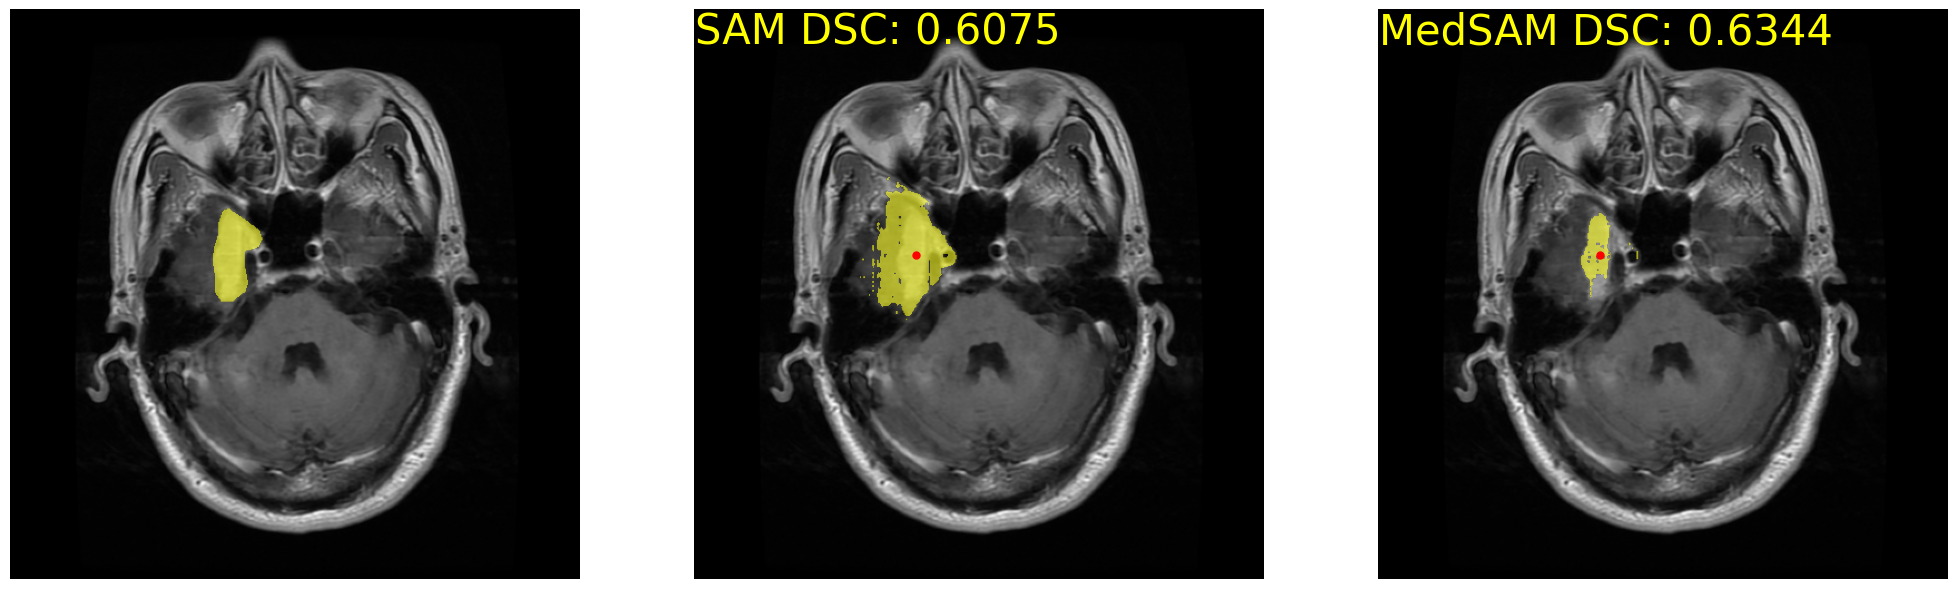

In [20]:
#%% visualize the segmentation results of the middle slice
# visualization functions
# source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
# change color to avoid red and green
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))    

def show_point(point, ax):
    ax.plot(point[0], point[1], marker='o', color='red', markersize=5)  # red point

_, axs = plt.subplots(1, 3, figsize=(25, 25))
axs[0].imshow(image_data)
show_mask(gt_data>0, axs[0])
# show_box(box_np[img_id], axs[0])
# axs[0].set_title('Mask with Tuned Model', fontsize=20)
axs[0].axis('off')

axs[1].imshow(image_data)
show_mask(ori_sam_seg, axs[1])
for i in range(num_points):
    show_point(points[i], axs[1])
# add text to image to show dice score
axs[1].text(0.5, 0.5, 'SAM DSC: {:.4f}'.format(ori_sam_dsc), fontsize=30, horizontalalignment='left', verticalalignment='top', color='yellow')
# axs[1].set_title('Mask with Untuned Model', fontsize=20)
axs[1].axis('off')

axs[2].imshow(image_data)
show_mask(medsam_seg, axs[2])
for i in range(num_points):
    show_point(points[i], axs[2])
# add text to image to show dice score
axs[2].text(0.5, 0.5, 'MedSAM DSC: {:.4f}'.format(medsam_dsc), fontsize=30, horizontalalignment='left', verticalalignment='top', color='yellow')
# axs[2].set_title('Ground Truth', fontsize=20)
axs[2].axis('off')
plt.show()  
plt.subplots_adjust(wspace=0.01, hspace=0)
# save plot
# FFF_3
# plt.savefig(join(model_save_path, "output_test_gaussian_center" + '.png'), bbox_inches='tight', dpi=300)
plt.close()